In [1]:
import psrchive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import matplotlib

import astropy.time
import astropy.coordinates
import astropy.units

import dedispersion

%matplotlib inline

In [2]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})
sns.set_style('white', rc={'axes.linewidth': 0.5})

### Telescope State

In [3]:
# Telescope pointing
eventUTCStr = '2018-03-01 07:34:19.76'
eventUTC = astropy.time.Time(eventUTCStr)
print eventUTC

c = astropy.coordinates.SkyCoord('06h12m40s', '+04d33m40s', frame='icrs', equinox='J2000')
print c
print c.galactic

eventGall = c.galactic.l.value
eventGalb = c.galactic.b.value

galCoords = astropy.coordinates.SkyCoord(eventGall, eventGalb, frame=astropy.coordinates.Galactic,\
                                         unit='deg', equinox='J2000')
print galCoords

# Parkes location
# https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_2.html
siteLat = -32.99778
siteLong = 148.26292
siteLoc = astropy.coordinates.EarthLocation(lat=siteLat * astropy.units.deg, lon=siteLong * astropy.units.deg,\
                                  height=414.80 * astropy.units.m)
print siteLoc

print galCoords.transform_to(astropy.coordinates.AltAz(obstime=eventUTC, location=siteLoc))

print galCoords.transform_to('icrs')

2018-03-01 07:34:19.760
<SkyCoord (ICRS): (ra, dec) in deg
    ( 93.16666667,  4.56111111)>
<SkyCoord (Galactic): (l, b) in deg
    ( 204.40615434, -6.49451056)>
<SkyCoord (Galactic): (l, b) in deg
    ( 204.40615434, -6.49451056)>
(-4554234.701509818, 2816825.9185967753, -3453978.054094455) m


<SkyCoord (AltAz: obstime=2018-03-01 07:34:19.760, location=(-4554234.701509818, 2816825.9185967753, -3453978.054094455) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 45.60434017,  41.44415466)>
<SkyCoord (ICRS): (ra, dec) in deg
    ( 93.16666667,  4.56111111)>


/usr/local/lib/python2.7/dist-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [4]:
jup = astropy.coordinates.get_body('jupiter', eventUTC, siteLoc)
print jup
sun = astropy.coordinates.get_body('sun', eventUTC, siteLoc)
print sun
moon = astropy.coordinates.get_body('moon', eventUTC, siteLoc)
print moon

<SkyCoord (GCRS: obstime=2018-03-01 07:34:19.760, obsgeoloc=( 2616497.2750334,  4668934.93099713, -3458397.74896443) m, obsgeovel=(-340.46414438,  190.79801265,  0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    ( 230.78867373, -17.34460831,  5.04082592)>
<SkyCoord (GCRS: obstime=2018-03-01 07:34:19.760, obsgeoloc=( 2616497.2750334,  4668934.93099713, -3458397.74896443) m, obsgeovel=(-340.46414438,  190.79801265,  0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    ( 341.91505553, -7.66240386,  0.99079528)>
<SkyCoord (GCRS: obstime=2018-03-01 07:34:19.760, obsgeoloc=( 2616497.2750334,  4668934.93099713, -3458397.74896443) m, obsgeovel=(-340.46414438,  190.79801265,  0.) m / s): (ra, dec, distance) in (deg, deg, km)
    ( 154.16781462,  13.09830426,  367005.83470164)>


### Data Prep

See this [post](https://griffinfoster.github.io/BL_dspsr/).

---

### Load Archive Files

In [5]:
def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    print (1. / (2. * np.pi * tSigma * fSigma))
    #return (1. / (2. * np.pi * tSigma * fSigma)) * taper
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg, norm='ortho') * np.fft.fft2(img, norm='ortho'),\
                                        norm='ortho')).real

In [6]:
tInt = 0.7489828571428683 # seconds, HARDCODE

In [7]:
# load dynamic spectra
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.ar')
upperAr = psrchive.Archive_load('../data/upper_halfband/FRB180301_upper.calibP')
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.RM') # RM -3160
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.RM0') # 3160

#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.ar')
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.calibP')
lowerAr = psrchive.Archive_load('../data/lower_halfband/FRB180301_lower.rfi')
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.RM') # RM -3160
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.RM0') # RM 3160

In [8]:
# Baseline removal
upperAr.remove_baseline()
lowerAr.remove_baseline()

# Convert data to Stokes
upperAr.convert_state('Stokes')
lowerAr.convert_state('Stokes')

In [9]:
freq_lo = upperAr.get_centre_frequency() - upperAr.get_bandwidth()/2.0
freq_hi = upperAr.get_centre_frequency() + upperAr.get_bandwidth()/2.0
print freq_lo
print freq_hi

freq_lo = lowerAr.get_centre_frequency() - lowerAr.get_bandwidth()/2.0
freq_hi = lowerAr.get_centre_frequency() + lowerAr.get_bandwidth()/2.0
print freq_lo
print freq_hi

deltaNu = upperAr.get_bandwidth() / upperAr.get_nchan()
freqsMHz = np.arange(upperAr.get_nchan() + lowerAr.get_nchan()) * deltaNu + (0.5 * deltaNu) +\
        (upperAr.get_centre_frequency() - upperAr.get_bandwidth()/2.0)
print freqsMHz

1513.75
1359.75
1359.75
1205.75
[ 1513.6953125  1513.5859375  1513.4765625 ...,  1206.0234375  1205.9140625
  1205.8046875]


In [10]:
upperData = upperAr.get_data()
lowerData = lowerAr.get_data()
upperWgts = upperAr.get_weights()
lowerWgts = lowerAr.get_weights()

print upperWgts.shape
for sint in np.arange(upperData.shape[0]):
    for pol in np.arange(upperData.shape[1]):
        upperData[sint,pol] = np.multiply(upperData[sint,pol].T, upperWgts[sint]).T
        lowerData[sint,pol] = np.multiply(lowerData[sint,pol].T, lowerWgts[sint]).T

print upperData.shape
print lowerData.shape

data = np.concatenate((upperData, lowerData), axis=2)
print data.shape

(1, 1408)
(1, 4, 1408, 32768)
(1, 4, 1408, 32768)
(1, 4, 2816, 32768)


In [11]:
# normalization region
phase0 = 0.5
phase1 = 0.8
phase = np.linspace(0, 1, data.shape[3])
phase0Idx = np.argmin(np.abs(phase - phase0))
phase1Idx = np.argmin(np.abs(phase - phase1))
subData = data[:,:,:,phase0Idx:phase1Idx]
normBandpass = np.mean(subData[0], axis=2)

---

### DM-trail S/N Maximization

In [12]:
# DM Search on Stokes I
normData = (data[0,0].T - normBandpass[0].T).T
print normData.shape

(2816, 32768)


In [13]:
minDM = -20.
maxDM = 20.
dmStep = 0.1

testDMs = np.arange(minDM, maxDM, dmStep)
dmSpace = np.zeros((testDMs.shape[0], normData.shape[1]))

for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.mean(dedispersion.incoherent(freqsMHz * 1e6, normData.T, tInt / normData.shape[1],\
                                                       dm, boundary='wrap'), axis=1)

17499
0.0936228571429


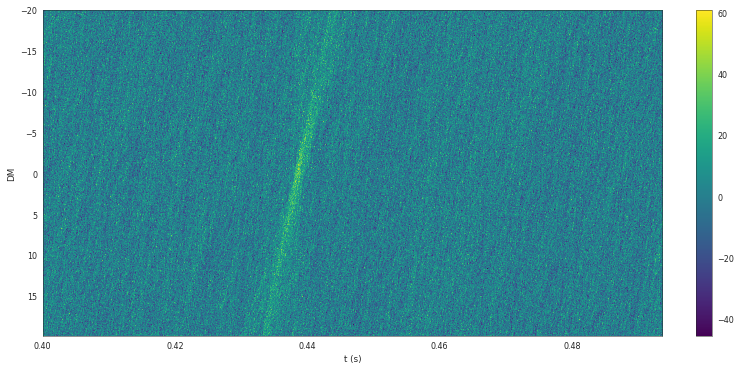

In [14]:
tStart = 0.4
tStartIdx = int( tStart / (tInt / dmSpace.shape[1]))
tWidthSamples = 4096
print tStartIdx
print tWidthSamples * (tInt / dmSpace.shape[1])
dmSpaceSub = dmSpace[:,tStartIdx:tStartIdx+tWidthSamples]

cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.imshow(dmSpaceSub, aspect='auto', extent=(tStart, \
                tStart + tWidthSamples * (tInt / dmSpace.shape[1]),\
                testDMs[-1], testDMs[0]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM')
plt.xlabel('t (s)')
plt.colorbar(fraction=0.025)

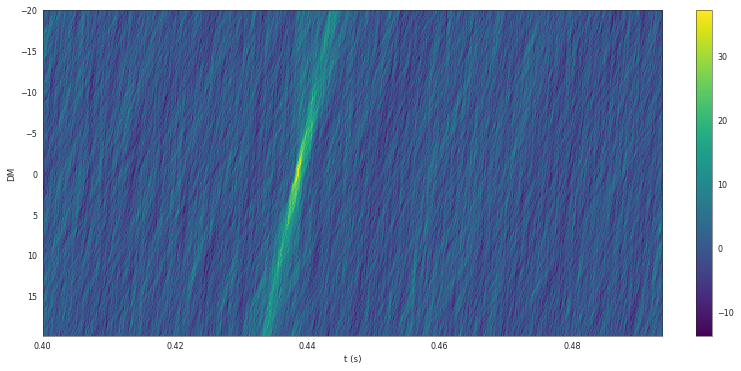

In [15]:
# binning DM space data
binFactor = 8
dmSpaceSubBin =  np.mean(dmSpaceSub.reshape((dmSpaceSub.shape[0], dmSpaceSub.shape[1]/binFactor, binFactor)),\
                         axis=2)
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.imshow(dmSpaceSubBin, aspect='auto', extent=(tStart, \
                tStart + tWidthSamples * (tInt / dmSpace.shape[1]),\
                testDMs[-1], testDMs[0]), cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (s)')
plt.colorbar(fraction=0.025)

521.6
9.78800173186


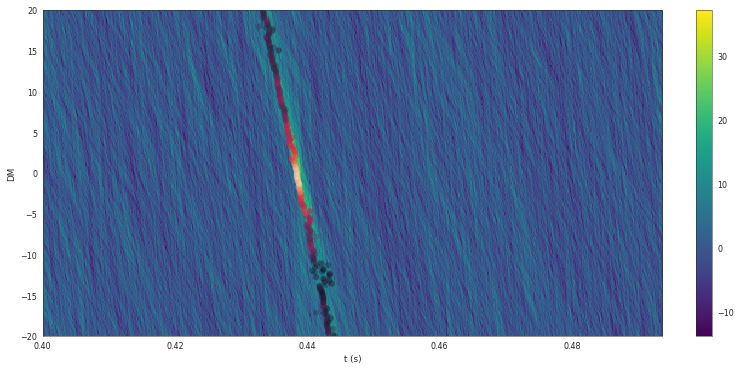

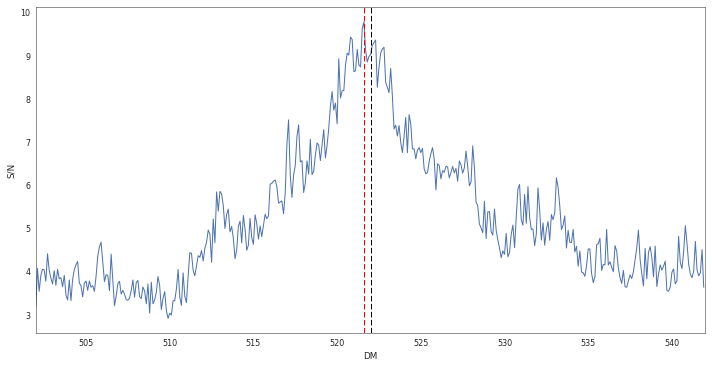

In [16]:
# S/N vs DM trial
maxIdx = np.argmax(dmSpaceSubBin, axis=1)

cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.imshow(dmSpaceSubBin, aspect='auto', extent=(tStart, \
                tStart + tWidthSamples * (tInt / dmSpace.shape[1]),\
                testDMs[-1], testDMs[0]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.colorbar(fraction=0.025)

plt.scatter(tStart + maxIdx * (binFactor* tInt / dmSpace.shape[1]), testDMs,\
            c=np.max(dmSpaceSubBin, axis=1), alpha=0.3)
plt.ylim(minDM, maxDM)
plt.ylabel('DM')
plt.xlabel('t (s)')

fig = plt.figure(figsize=(12,6)) # (width, height)

coherentDM = 522.
plt.plot(testDMs + coherentDM, np.max(dmSpaceSubBin, axis=1)/np.std(dmSpaceSubBin))
DMpeakSNR = coherentDM + testDMs[np.argmax(np.max(dmSpaceSubBin, axis=1)/np.std(dmSpaceSubBin))]
print DMpeakSNR
plt.axvline(coherentDM, ls='--', c='black')
plt.axvline(DMpeakSNR, ls='--', c='red')
plt.ylabel('S/N')
plt.xlabel('DM')
plt.xlim(minDM + coherentDM, maxDM + coherentDM)

print np.max(dmSpaceSubBin) / np.std(dmSpaceSubBin)

['ySigma', 'amp', 'xSigma', 'offset', 'theta', 'y0', 'x0'] ['x', 'y']
Parameters([('ySigma', <Parameter 'ySigma', 1.0, bounds=[-inf:inf]>), ('amp', <Parameter 'amp', 36.912215365232491, bounds=[-inf:inf]>), ('xSigma', <Parameter 'xSigma', 0.00018285714285714557, bounds=[-inf:inf]>), ('offset', <Parameter 'offset', 0.32866273993108336, bounds=[-inf:inf]>), ('theta', <Parameter 'theta', 0.0, bounds=[-inf:inf]>), ('y0', <Parameter 'y0', -0.39999999999972147, bounds=[-inf:inf]>), ('x0', <Parameter 'x0', 0.43840000000000057, bounds=[-inf:inf]>)])
[[Model]]
    Model(general2DGaussian)
[[Fit Statistics]]
    # function evals   = 67
    # data points      = 6360
    # variables        = 7
    chi-square         = 82303.205
    reduced chi-square = 12.955
    Akaike info crit   = 16298.027
    Bayesian info crit = 16345.332
[[Variables]]
    ySigma:   8.46769562 +/- 0.192074 (2.27%) (init= 1)
    amp:      24.9661854 +/- 0.212223 (0.85%) (init= 36.91222)
    xSigma:   0.00061211 +/- 5.19e-06 (

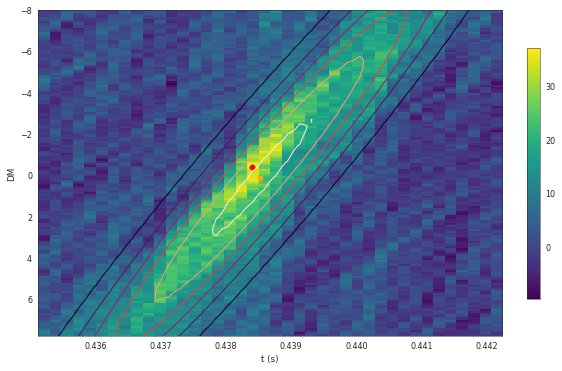

In [17]:
# Fit 2-D Gaussian
def general2DGaussian(x, y, amp=1., x0=0., y0=0., xSigma=1., ySigma=1., theta=0., offset=0.):
    """General 2-D Gaussian function, see https://en.wikipedia.org/wiki/Gaussian_function"""
    aa = (np.cos(theta)**2.) / (2. * xSigma**2.) + (np.sin(theta)**2.) / (2. * ySigma**2.)
    bb = -1. * (np.sin(2. * theta)) / (4. * xSigma**2.) + (np.sin(2. * theta)) / (4. * ySigma**2.)
    cc = (np.sin(theta)**2.) / (2. * xSigma**2.) + (np.cos(theta)**2.) / (2. * ySigma**2.)
    return amp * np.exp(-1. * (aa * (x - x0)**2. + 2. * bb * (x - x0) * (y - y0) + cc * (y - y0)**2.)) + offset

dmOptModel = lmfit.models.Model(general2DGaussian, independent_vars=['x', 'y'])
print dmOptModel.param_names, dmOptModel.independent_vars

tRange = tStart + (tInt / (binFactor * dmSpaceSubBin.shape[1])) * np.arange(dmSpaceSubBin.shape[1])

# select region around peak
tRgn0 = 0.435
tRgn1 = 0.4425
dmRgn0 = -8.
dmRgn1 = 8.

tRgn0Idx = np.argwhere((tRange > tRgn0) & (tRange < tRgn1))[0,0]
tRgn1Idx = np.argwhere((tRange > tRgn0) & (tRange < tRgn1))[-1,0]
dmRgn0Idx = np.argwhere((testDMs > dmRgn0) & (testDMs < dmRgn1))[0,0]
dmRgn1Idx = np.argwhere((testDMs > dmRgn0) & (testDMs < dmRgn1))[-1,0]
tRangeRgn = tRange[tRgn0Idx:tRgn1Idx]
dmRgn = testDMs[dmRgn0Idx:dmRgn1Idx]
dmSpaceSubBinRgn = dmSpaceSubBin[dmRgn0Idx:dmRgn1Idx, tRgn0Idx:tRgn1Idx]

cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(9,6)) # (width, height)

plt.imshow(dmSpaceSubBinRgn, aspect='auto', extent=(tRangeRgn[0], tRangeRgn[-1],\
                dmRgn[-1], dmRgn[0]), cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (s)')
plt.colorbar(fraction=0.025)

rgnSNR = np.max(dmSpaceSubBinRgn, axis=0) / np.std(dmSpaceSubBin)
plt.scatter(tRangeRgn[np.argmax(rgnSNR)], dmRgn[np.argmax(dmSpaceSubBinRgn[:, np.argmax(rgnSNR)])], c='red')

params = dmOptModel.make_params(ySigma=1., amp=np.max(dmSpaceSubBinRgn)-np.mean(dmSpaceSubBin),\
                                xSigma=tInt / (binFactor * dmSpaceSubBin.shape[1]),\
                                offset=np.mean(dmSpaceSubBin), theta=0.,\
                                y0=dmRgn[np.argmax(dmSpaceSubBinRgn[:, np.argmax(rgnSNR)])],
                                x0=tRangeRgn[np.argmax(rgnSNR)])
print params

xx = np.repeat(np.expand_dims(tRangeRgn, axis=0), dmSpaceSubBinRgn.shape[0], axis=0)
xFlat = xx.flatten()
yy = np.repeat(np.expand_dims(dmRgn, axis=1), dmSpaceSubBinRgn.shape[1], axis=1)
yFlat = yy.flatten()
result = dmOptModel.fit(dmSpaceSubBinRgn.flatten(), params, x=xFlat, y=yFlat)
print result.fit_report()

fitGauss = general2DGaussian(xFlat, yFlat, amp=result.params['amp'].value, x0=result.params['x0'].value,\
                  y0=result.params['y0'].value, xSigma=result.params['xSigma'].value,\
                  ySigma=result.params['ySigma'].value, theta=result.params['theta'].value,\
                  offset=result.params['offset'].value)
fitGauss = fitGauss.reshape(dmRgn.shape[0], tRangeRgn.shape[0])
plt.contour(xx, yy, fitGauss)
plt.scatter(result.params['x0'].value, result.params['y0'].value, c='orange')

In [18]:
# extended DM-trail space search
minDM = -1000.
maxDM = 1000.
dmStep = 5.

testDMs = np.arange(minDM, maxDM, dmStep)
dmSpace = np.zeros((testDMs.shape[0], normData.shape[1]))

for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.mean(dedispersion.incoherent(freqsMHz * 1e6, normData.T, tInt / normData.shape[1],\
                                                       dm, boundary='wrap'), axis=1)

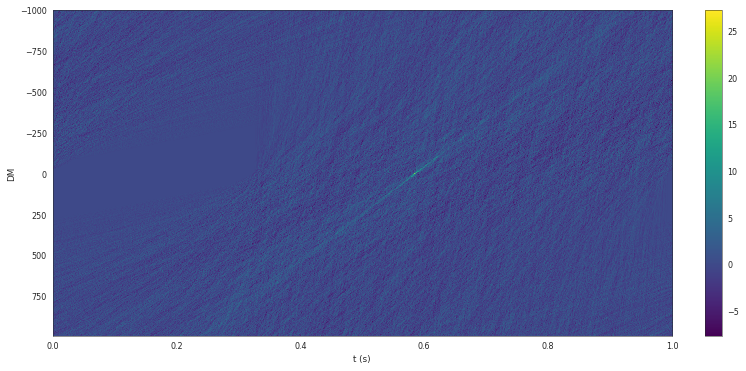

In [19]:
binFactor = 32
dmSpaceSubBin =  np.mean(dmSpace.reshape((dmSpace.shape[0], dmSpace.shape[1]/binFactor, binFactor)),\
                         axis=2)

cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.imshow(dmSpaceSubBin, aspect='auto', extent=(0,1,\
                testDMs[-1], testDMs[0]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM')
plt.xlabel('t (s)')
plt.colorbar(fraction=0.025)

#### DM Excess

* NE2001: https://www.nrl.navy.mil/rsd/RORF/ne2001/
* YMW16: http://www.xao.ac.cn/ymw16/

In [12]:
import scipy.integrate

# Inoue 2004 - Probing the cosmic reionization history and local environment of gamma-ray bursts through
# radio dispersion
def DM_IGM(z):
    """IGM DM, see Eq. 2 of Inoue 2004 """
    Omega_m = 0.27
    Omega_lambda = 0.73
    cc = 299792.458 # km/s
    Xe = 1.
    Ne0 = 2.1e-7 # cm^-3
    H0 = 71. * (1. / 1e6) # km / s / pc
    return scipy.integrate.quad(lambda zp: (cc * Xe * Ne0 * (1. + zp)) /\
                                (np.sqrt(Omega_m * ((1. + zp)**3.) + Omega_lambda) * H0),\
                                0., z)

print DM_IGM(1.)

zz = np.linspace(0., 0.5, 1000)
DMz = []
for zVal in zz: DMz.append(DM_IGM(zVal)[0])

(1013.9090063474928, 1.1256651237218005e-11)


In [13]:
DMpeakSNR = 521.6

# NE2001
DMgalaxyNE2001 = 150.60
DMexcessNE2001 = DMpeakSNR / DMgalaxyNE2001
print 'NE2001:'
print 'DM Excess:', DMpeakSNR - DMgalaxyNE2001
print 'DM Excess fraction:', DMexcessNE2001

# YMW16
DMgalaxyYWM16 = 252.34
DMexcessYWM16 = DMpeakSNR / DMgalaxyYWM16
print 'YMW16:'
print 'DM Excess:', DMpeakSNR - DMgalaxyYWM16
print 'DM Excess fraction:', DMexcessYWM16

NE2001:
DM Excess: 371.0
DM Excess fraction: 3.46347941567
YMW16:
DM Excess: 269.26
DM Excess fraction: 2.06705238963


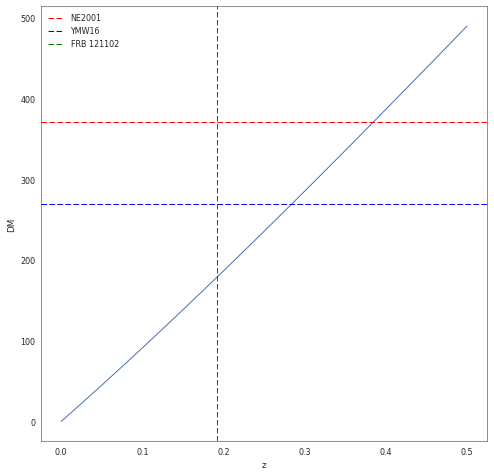

In [14]:
fig = plt.figure(figsize=(8,8)) # (width, height)

plt.plot(zz, DMz)
plt.axhline(DMpeakSNR - DMgalaxyNE2001, ls='--', c='red', label='NE2001')
plt.axhline(DMpeakSNR - DMgalaxyYWM16, ls='--', c='blue', label='YMW16')

plt.axvline(0.192, ls='--', c='green', label='FRB 121102')

plt.ylabel('DM')
plt.xlabel('z')
plt.legend()

---

### RM Fit Solution

In [3]:
rmSpectrum = np.loadtxt('../data/rm_spectrum.txt')

-3153.15


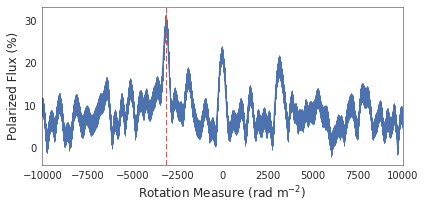

In [7]:
snrMaxRM = rmSpectrum[np.argmax(rmSpectrum[:,1]), 0]
print snrMaxRM

sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(6,3)) # (width, height)

ax = fig.add_subplot(111)

plt.errorbar(rmSpectrum[:,0], rmSpectrum[:,1], yerr=rmSpectrum[:,2])

plt.axvline(snrMaxRM, c='indianred', ls='--')

plt.xlim(rmSpectrum[0,0], rmSpectrum[-1,0])

plt.xlabel('Rotation Measure (rad m$^{-2}$)', fontsize=12)
plt.ylabel('Polarized Flux (%)', fontsize=12)

ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../figures/rmfit.pdf')

### Dynamic Spectrum

In [17]:
# select a region in phase
phase0 = 0.575
phase1 = 0.597

phase = np.linspace(0, 1, data.shape[3])
phase0Idx = np.argmin(np.abs(phase - phase0))
phase1Idx = np.argmin(np.abs(phase - phase1))
subData = data[:,:,:,phase0Idx:phase1Idx]

#ts0 = 1000. * tInt * phase0 # ms
#ts1 = 1000. * tInt * phase1 # ms
ts0 = 0. # ms
ts1 = 1000. * tInt * (phase1 - phase0) # ms

In [18]:
# normalize (remove bandpass)
applyNorm = False

if applyNorm:
    normSubData = np.zeros_like(subData)
    for pIdx in range(4):
        #normSubData[0,pIdx] = (subData[0,pIdx].T - np.mean(subData[0,pIdx], axis=1).T).T
        normSubData[0,pIdx] = (subData[0,pIdx].T - normBandpass[pIdx].T).T
else:
    normSubData = subData.copy()

Using Measured SEFD: 37.041212 Jy
16.2746


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide


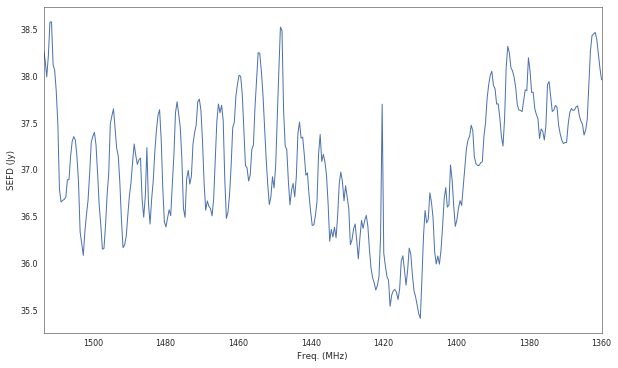

In [19]:
# Flux Calibration
applyHistScaling = False # Historical SEFD scaling
applyScaling = True # Measured SEFD scaling
npol = 2 # 2 for Stokes, 1 for coherency

if applyHistScaling:
    SEFD = 30. # Jy, https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_3.html
    print 'Using Historical SEFD: %f Jy'%SEFD
    
    fluxScaling = SEFD / np.sqrt(npol * np.abs(deltaNu * 1e6) * tInt/data.shape[3])
    #print fluxScaling
    #print np.std(normSubData[0,0], axis=1)
    
    scaleFactor = fluxScaling / np.std(normSubData[0,0], axis=1)
    scaleFactor[scaleFactor == np.inf] = 0.
    scaleSubData = np.zeros_like(normSubData)
    for pIdx in range(4):
        scaleSubData[0,pIdx] = (normSubData[0,pIdx].T * scaleFactor).T
        
elif applyScaling:
    measuredSEFD = np.loadtxt('../data/frb180301_sefd_cal.csv', delimiter=',') # From Danny, see fb180301_SEFD.pdf
    
    fig = plt.figure(figsize=(10,6)) # (width, height)
    plt.plot(measuredSEFD[:,0], measuredSEFD[:,1])
    plt.xlabel('Freq. (MHz)')
    plt.ylabel('SEFD (Jy)')
    plt.xlim(measuredSEFD[0,0], measuredSEFD[-1,0])
    SEFD = measuredSEFD[:,1].mean() # use the mean SEFD
    print 'Using Measured SEFD: %f Jy'%SEFD
    
    fluxScaling = SEFD / np.sqrt(npol * np.abs(deltaNu * 1e6) * tInt/data.shape[3])
    #print fluxScaling
    #print np.std(normSubData[0,0], axis=1)
    scaleFactor = fluxScaling / np.std(normSubData[0,0], axis=1)
    scaleFactor[scaleFactor == np.inf] = 0.
    scaleSubData = np.zeros_like(normSubData)
    for pIdx in range(4):
        scaleSubData[0,pIdx] = (normSubData[0,pIdx].T * scaleFactor).T
        
else:
    scaleSubData = normSubData.copy() # no scaling
    
print np.std(scaleSubData[0,0])

(46,)


/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


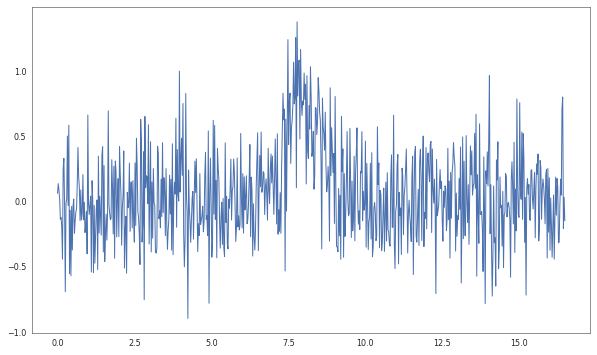

In [20]:
import scipy.signal

fig = plt.figure(figsize=(10,6)) # (width, height)

rawTimeSeries = scaleSubData[0,0].mean(axis=0)

print scipy.signal.decimate(rawTimeSeries, 16).shape

ts = np.linspace(ts0, ts1, scaleSubData.shape[3])
plt.plot(ts, rawTimeSeries)
#plt.plot(scipy.signal.decimate(rawTimeSeries, 8))

(1390, 1431)

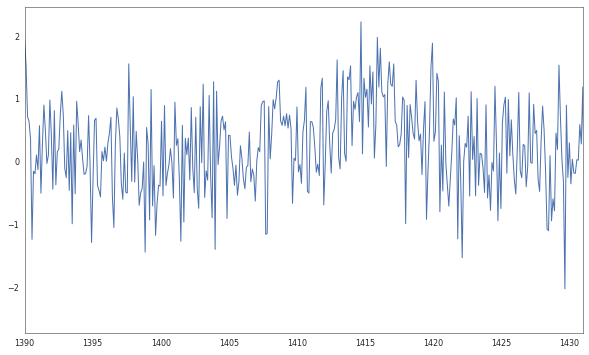

In [21]:
fig = plt.figure(figsize=(10,6)) # (width, height)

rawSpectrums = scaleSubData[0,0].mean(axis=1)

plt.plot(freqsMHz, rawSpectrums)
plt.xlim(1390, 1431)

In [22]:
# Gaussian filter
applyGauss = True

if applyGauss:
    fGauss = 2.
    tGauss = 4.
    gaussSubData = np.zeros_like(normSubData)
    gaussImg = gaussianFilter(scaleSubData[0,0].shape, tGauss, fGauss)
    for pIdx in range(4):
        gaussSubData[0,pIdx] = convolveTaper(gaussImg, normSubData[0,pIdx])
else:
    gaussSubData = scaleSubData.copy()
    
print np.std(gaussSubData[0,0])

0.0198943678865
1.79858


In [23]:
# find peak
print gaussSubData[0,0].shape
peakIdx = np.unravel_index(np.argmax(gaussSubData[0,0]), gaussSubData[0,0].shape)
print peakIdx
tWidth = 12
#tIdx0 = peakIdx[1] - tWidth
#tIdx1 = peakIdx[1] + tWidth

#tIdx0 = 330
#tIdx1 = 370

tIdx0 = 325
tIdx1 = 375

(2816, 721)
(900, 339)


1513.6953125 1205.8046875
1.23039


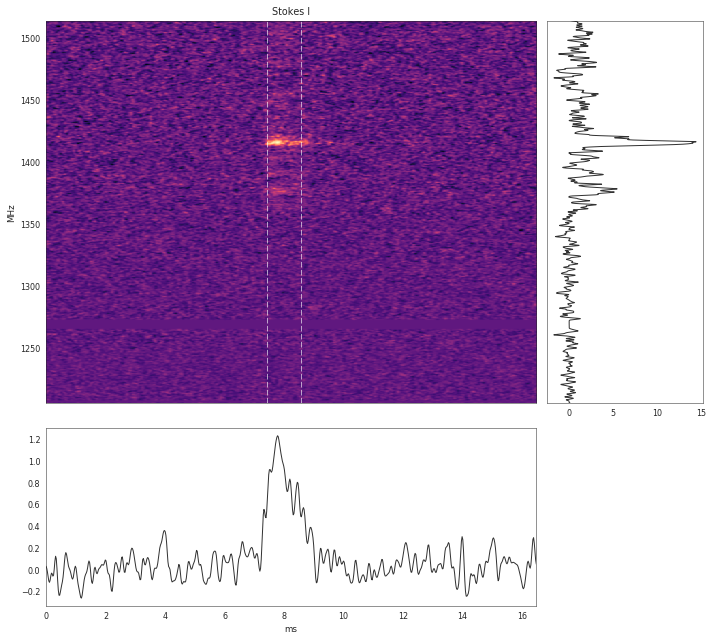

In [24]:
# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

print freqsMHz[0], freqsMHz[-1]

ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('../figures/180301_stokesI_dedsip.png')

print np.max(timeSeries[0,0])

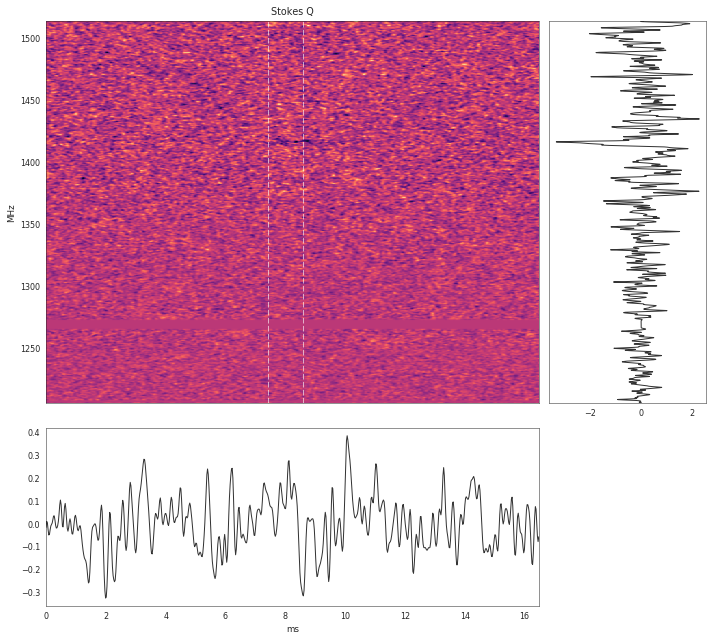

In [25]:
# Stokes Q
polStr = 'Stokes Q'
pIdx = 1

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

#dSpec = plt.imshow(data[0,pIdx], aspect='auto',\
dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

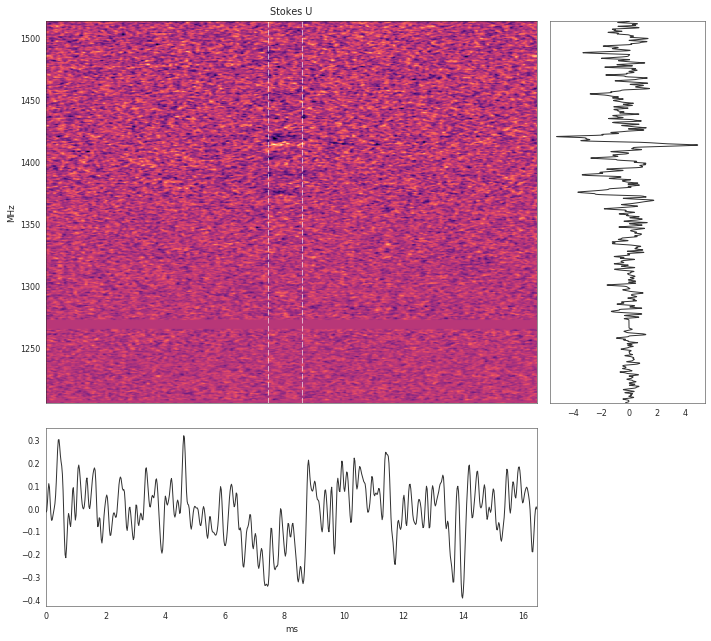

In [26]:
# Stokes U
polStr = 'Stokes U'
pIdx = 2

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

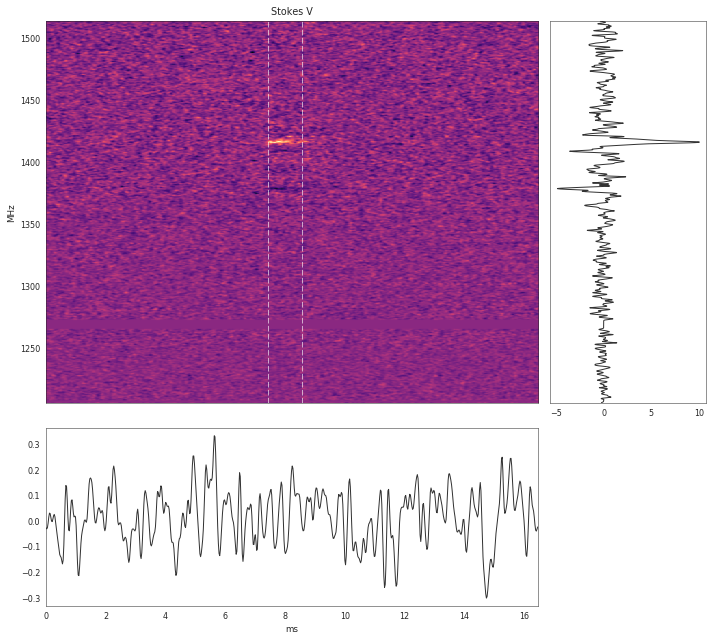

In [27]:
# Stokes V
polStr = 'Stokes V'
pIdx = 3

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

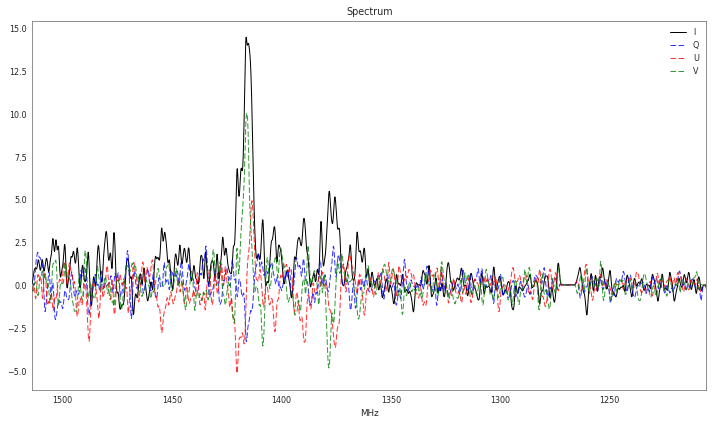

In [28]:
fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(freqsMHz, spectrum[0,0], 'k', label='I', alpha=1.)
plt.plot(freqsMHz, spectrum[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,2], 'r--', label='U', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,3], 'g--', label='V', alpha=0.8)

plt.xlim(freqsMHz[0], freqsMHz[-1])
#plt.xlim(1250., 1240.)
plt.xlabel('MHz')

plt.title('Spectrum')
plt.legend()
plt.tight_layout()

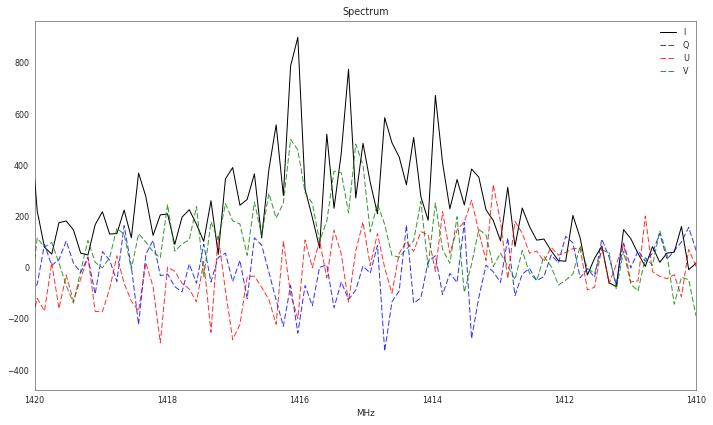

In [29]:
rawSpectrum = np.mean(subData[:,:,:,tIdx0:tIdx1], axis=3)

fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(freqsMHz, rawSpectrum[0,0], 'k', label='I', alpha=1.)
plt.plot(freqsMHz, rawSpectrum[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(freqsMHz, rawSpectrum[0,2], 'r--', label='U', alpha=0.8)
plt.plot(freqsMHz, rawSpectrum[0,3], 'g--', label='V', alpha=0.8)

plt.xlim(freqsMHz[0], freqsMHz[-1])
#plt.xlim(1250., 1240.)
plt.xlim(1420., 1410.)
plt.xlabel('MHz')

plt.title('Spectrum')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/frb180301_spectrum.png')

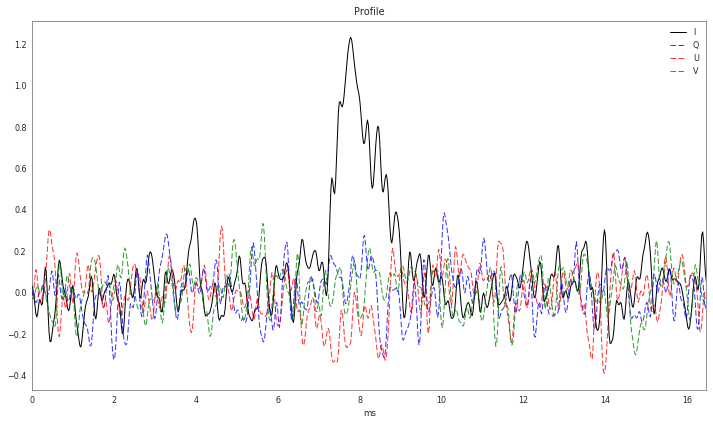

In [30]:
fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(ts, timeSeries[0,0], 'k', label='I', alpha=1.)
plt.plot(ts, timeSeries[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(ts, timeSeries[0,2], 'r--', label='U', alpha=0.8)
plt.plot(ts, timeSeries[0,3], 'g--', label='V', alpha=0.8)

plt.xlim(ts0, ts1)
plt.xlabel('ms')

plt.title('Profile')
plt.legend()
plt.tight_layout()

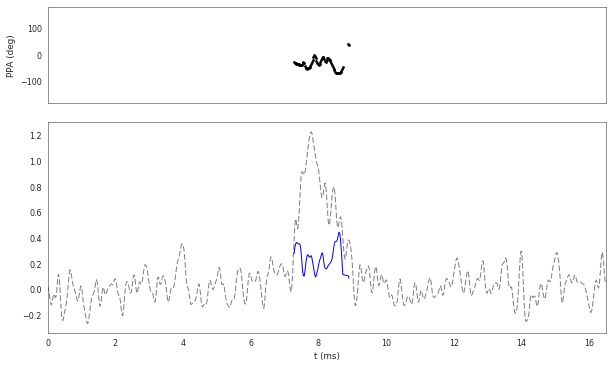

In [31]:
# Position angle and linear polarization fraction
minThresh = 2.25

highSNRidx = np.argwhere(timeSeries[0,0] > minThresh * np.std(timeSeries))

fig = plt.figure(figsize=(10,6)) # (width, height)

LL = np.sqrt((timeSeries[0,1][highSNRidx])**2. + (timeSeries[0,2][highSNRidx])**2.)
linPolFrac = LL / timeSeries[0,0][highSNRidx]
PPA = (0.5 * np.arctan2(timeSeries[0,2][highSNRidx], timeSeries[0,1][highSNRidx])) * (180. / np.pi)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)

plt.plot(ts[highSNRidx], PPA, 'k.')
plt.xlim(ts0, ts1)
plt.ylim(-180., 180.)
ax1.get_xaxis().set_visible(False)
plt.ylabel('PPA (deg)')

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=2)

plt.plot(ts, timeSeries[0,0], 'k--', label='I', alpha=0.5)
plt.plot(ts[highSNRidx], LL, 'b-')

plt.xlim(ts0, ts1)
plt.xlabel('t (ms)')

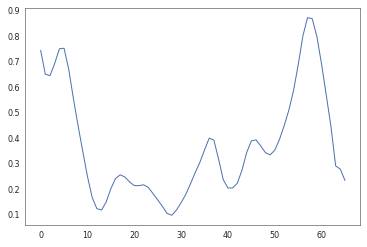

In [32]:
plt.plot(linPolFrac)

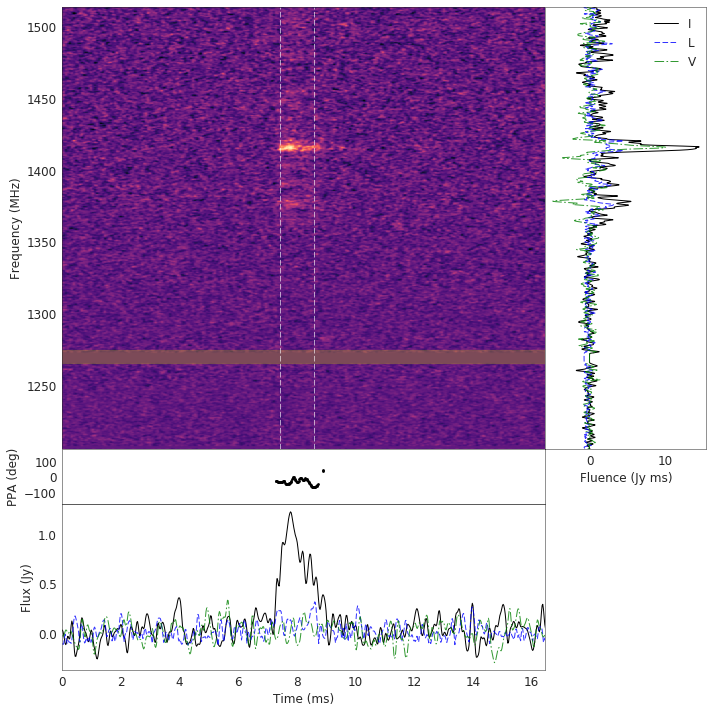

In [33]:
# Manuscript figure
pIdx = 0

cmap = 'magma'
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})
sns.set_style('white', rc={'axes.linewidth': 0.5})

#fig = plt.figure(figsize=(12,12)) # (width, height)
fig = plt.figure(figsize=(10,10)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

gs = matplotlib.gridspec.GridSpec(12,4)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:8,0:3])
#ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])

plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.axhspan(1265., 1275., alpha=0.3, color='y')

plt.ylabel('Frequency (MHz)', fontsize=12)
ax1.tick_params(labelsize=12)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[9:12,0:3])
#ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)
plt.plot(ts, timeSeries[0,0], 'k', label='I', alpha=1.)
#plt.plot(ts, timeSeries[0,1], 'b--', label='Q', alpha=0.8)
#plt.plot(ts, timeSeries[0,2], 'r--', label='U', alpha=0.8)
tsLL = np.sqrt(timeSeries[0,1]**2. + timeSeries[0,2]**2.)
tsLL -= np.median(tsLL)
plt.plot(ts, tsLL, 'b--', label='L', alpha=0.8)
plt.plot(ts, timeSeries[0,3], 'g-.', label='V', alpha=0.8)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim(ts0, ts1)
plt.ylabel('Flux (Jy)', fontsize=12)

ax2.tick_params(labelsize=12)
#plt.legend()

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot(gs[0:8,3:4])
#ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.sum(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,0], np.flipud(freqsMHz), 'k', label='I', alpha=1.)
#plt.plot(spectrum[0,1], np.flipud(freqsMHz), 'b--', label='Q', alpha=0.8)
#plt.plot(spectrum[0,2], np.flipud(freqsMHz), 'r--', label='U', alpha=0.8)
spectrumLL = np.sqrt(spectrum[0,1]**2. + spectrum[0,2]**2.)
spectrumLL -= np.median(spectrumLL)
plt.plot(spectrumLL, np.flipud(freqsMHz), 'b--', label='L', alpha=0.8)
plt.plot(spectrum[0,3], np.flipud(freqsMHz), 'g-.', label='V', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('Fluence (Jy ms)', fontsize=12)
plt.legend(fontsize=12)

ax3.tick_params(labelsize=12)

ax3.get_yaxis().set_visible(False)

ax4 = plt.subplot(gs[8:9,0:3])

plt.plot(ts[highSNRidx], PPA, 'k.')
plt.xlim(ts0, ts1)
plt.ylim(-180., 180.)
ax1.get_xaxis().set_visible(False)
plt.ylabel('PPA (deg)', fontsize=12)

ax4.tick_params(labelsize=12)

ax4.get_xaxis().set_visible(False)

plt.subplots_adjust(wspace=0., hspace=0.)

plt.tight_layout()
plt.savefig('../figures/dynamic_spectrum.pdf')
#plt.savefig('180301_dynamic_spectrum_dedisp.png')

### Scattering

In [58]:
%load_ext autoreload
%autoreload 2

import scatterutils

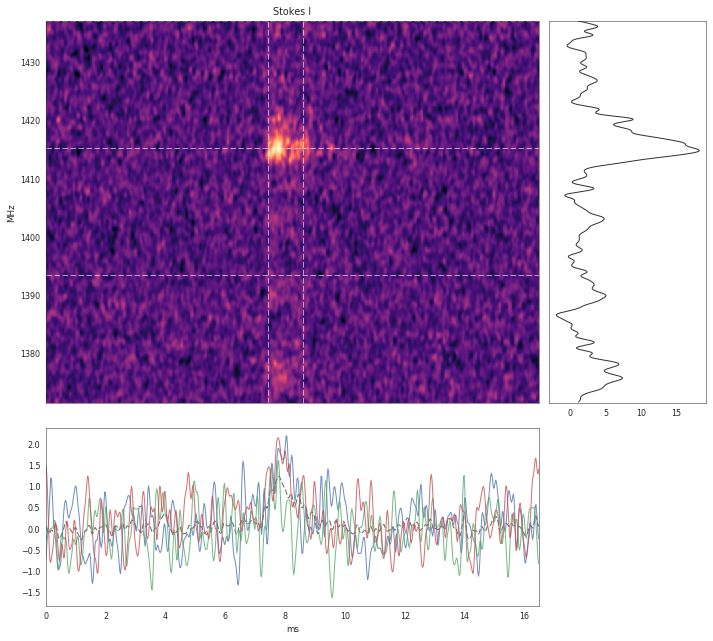

In [59]:
scatterNuIdx0 = 700
scatterNuIdx1 = 1300
nch = 3

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]
for nchIdx in np.arange(nch):
    plt.axhline(y=freqsMHz[scatterNuIdx1] + (scatterBW / nch)*(1+nchIdx), c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k--', alpha=0.6)

for nchIdx in np.arange(nch):
    plt.plot(ts, np.mean(gaussSubData[0,pIdx,nchIdx*timeSeries.shape[2]/nch:(nchIdx+1)*timeSeries.shape[2]/nch],\
                         axis=0), alpha=0.8)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

In [60]:
#Scattering: full band

### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = 'FRB180301.scattering.ascii'
pdvfile = scatterutils.writePDVtimeSeries(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1].T,\
                                          freqsMHz[scatterNuIdx0:scatterNuIdx1], ts1/1e3, nch=1,\
                                          src='FRB180301', ofn=pdvfilen)

Pulsar name: FRB180301
Number of channels: 1
Number of bins: 721
RMS: 0.781746
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:337
Rolling data by -23 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 89
    # data points      = 721
    # variables        = 5
    chi-square         = 66.889
    reduced chi-square = 0.093
    Akaike info crit   = -1704.248
    Bayesian info crit = -1681.345
[[Variables]]
    mu:      350.287130 +/- 0.418116 (0.12%) (init= 360)
    sigma:   7.50752269 +/- 0.491250 (6.54%) (init= 15)
    A:       9.92078384 +/- 0.684108 (6.90%) (init= 3.680907)
    tau:     31.2009752 +/- 1.370111 (4.39%) (init= 200)
    dc:     -0.25481150 +/- 0.012817 (5.03%) (init= 0)
    nbins:   721 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.944 
    C(A, tau)                    =  0.639 
    C(mu,

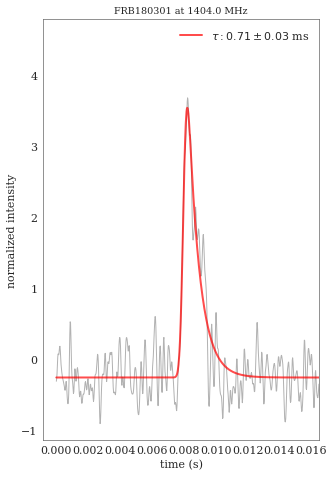

Tau (ms): 0.71
tau1GHz_alpha_4 (ms) ~ 2.77 



In [61]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

scatterFreqs, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [62]:
print 'Gaussian width (W10): %f ms pm %f'%((7.50719052 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)),\
                                     (0.491211 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)))

print 'Tau: %f ms pm %f'%((31.2009752 * (ts[1] - ts[0])), (1.370111 * (ts[1] - ts[0])))

Gaussian width (W10): 0.737382 ms pm 0.048248
Tau: 0.714053 ms pm 0.031356


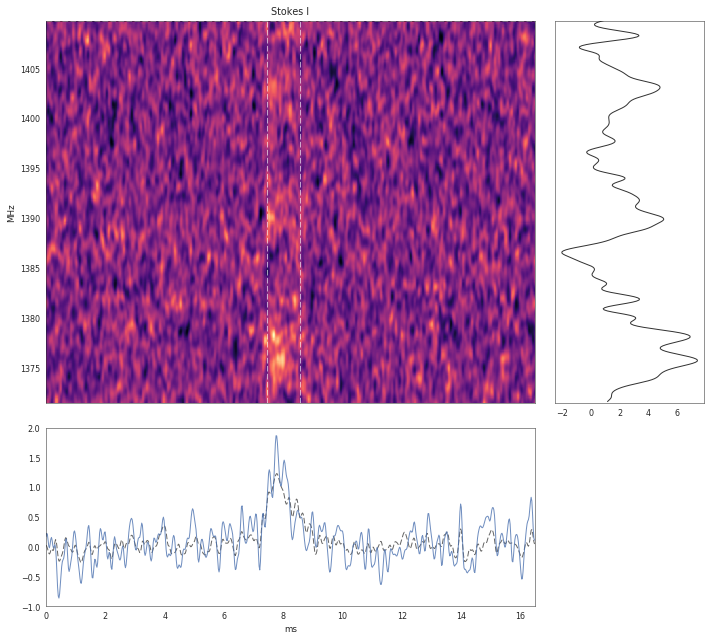

In [63]:
scatterNuIdx0 = 950
scatterNuIdx1 = 1300
nch = 1

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]
for nchIdx in np.arange(nch):
    plt.axhline(y=freqsMHz[scatterNuIdx1] + (scatterBW / nch)*(1+nchIdx), c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k--', alpha=0.6)

for nchIdx in np.arange(nch):
    plt.plot(ts, np.mean(gaussSubData[0,pIdx,nchIdx*timeSeries.shape[2]/nch:(nchIdx+1)*timeSeries.shape[2]/nch],\
                         axis=0), alpha=0.8)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

In [64]:
#Scattering: 1370 - 1410 MHz

### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = 'FRB180301.scattering.ascii'
pdvfile = scatterutils.writePDVtimeSeries(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1].T,\
                                          freqsMHz[scatterNuIdx0:scatterNuIdx1], ts1/1e3, nch=1,\
                                          src='FRB180301_1370-1410', ofn=pdvfilen)

Pulsar name: FRB180301_1370-1410
Number of channels: 1
Number of bins: 721
RMS: 0.589451
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:336
Rolling data by -24 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 120
    # data points      = 721
    # variables        = 5
    chi-square         = 92.966
    reduced chi-square = 0.130
    Akaike info crit   = -1466.904
    Bayesian info crit = -1444.000
[[Variables]]
    mu:      351.284489 +/- 0.780937 (0.22%) (init= 360)
    sigma:   7.88329347 +/- 0.892991 (11.33%) (init= 15)
    A:       5.94149252 +/- 0.710861 (11.96%) (init= 2.600115)
    tau:     28.3521648 +/- 2.375169 (8.38%) (init= 200)
    dc:     -0.15998392 +/- 0.014980 (9.36%) (init= 0)
    nbins:   721 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.940 
    C(A, tau)                    =  0.6

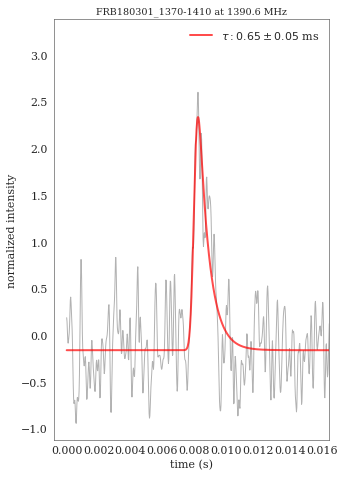

Tau (ms): 0.65
tau1GHz_alpha_4 (ms) ~ 2.42 



In [65]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

scatterFreqs, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [66]:
print 'Gaussian width (W10): %f ms pm %f'%((7.88329347 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)),\
                                     (0.892991 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)))

print 'Tau: %f ms pm %f'%((28.3521648 * (ts[1] - ts[0])), (2.375169 * (ts[1] - ts[0])))

Gaussian width (W10): 0.774324 ms pm 0.087713
Tau: 0.648856 ms pm 0.054357


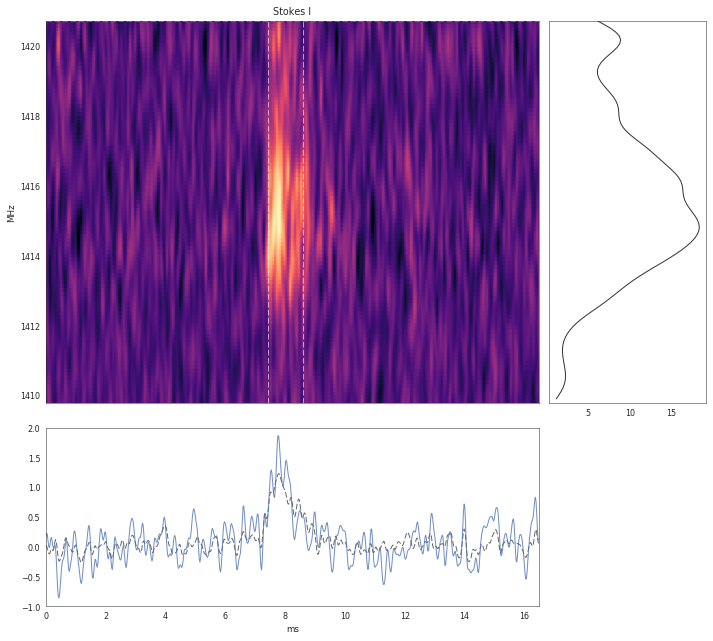

In [67]:
scatterNuIdx0 = 850
scatterNuIdx1 = 950
nch = 1

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]
for nchIdx in np.arange(nch):
    plt.axhline(y=freqsMHz[scatterNuIdx1] + (scatterBW / nch)*(1+nchIdx), c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k--', alpha=0.6)

for nchIdx in np.arange(nch):
    plt.plot(ts, np.mean(gaussSubData[0,pIdx,nchIdx*timeSeries.shape[2]/nch:(nchIdx+1)*timeSeries.shape[2]/nch],\
                         axis=0), alpha=0.8)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

In [68]:
#Scattering: bright scintile at 1415 MHz

### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = 'FRB180301.scattering.ascii'
pdvfile = scatterutils.writePDVtimeSeries(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1].T,\
                                          freqsMHz[scatterNuIdx0:scatterNuIdx1], ts1/1e3, nch=1,\
                                          src='FRB180301_1415', ofn=pdvfilen)

Pulsar name: FRB180301_1415
Number of channels: 1
Number of bins: 721
RMS: 2.199145
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:339
Rolling data by -21 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 65
    # data points      = 721
    # variables        = 5
    chi-square         = 463.004
    reduced chi-square = 0.647
    Akaike info crit   = -309.333
    Bayesian info crit = -286.430
[[Variables]]
    mu:      348.721134 +/- 0.383135 (0.11%) (init= 360)
    sigma:   7.22612839 +/- 0.461297 (6.38%) (init= 15)
    A:       30.7035138 +/- 2.058246 (6.70%) (init= 10.43732)
    tau:     35.1485800 +/- 1.362837 (3.88%) (init= 200)
    dc:     -0.76042394 +/- 0.034164 (4.49%) (init= 0)
    nbins:   721 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.948 
    C(A, tau)                    =  0.609 
    C

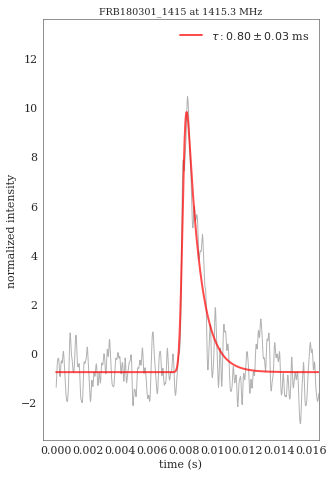

Tau (ms): 0.80
tau1GHz_alpha_4 (ms) ~ 3.22 



In [69]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

scatterFreqs, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [70]:
print 'Gaussian width (W10): %f ms pm %f'%((7.22612839 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)),\
                                     (0.461297 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)))

print 'Tau: %f ms pm %f'%((35.1485800 * (ts[1] - ts[0])), (1.362837 * (ts[1] - ts[0])))

Gaussian width (W10): 0.709775 ms pm 0.045310
Tau: 0.804396 ms pm 0.031189


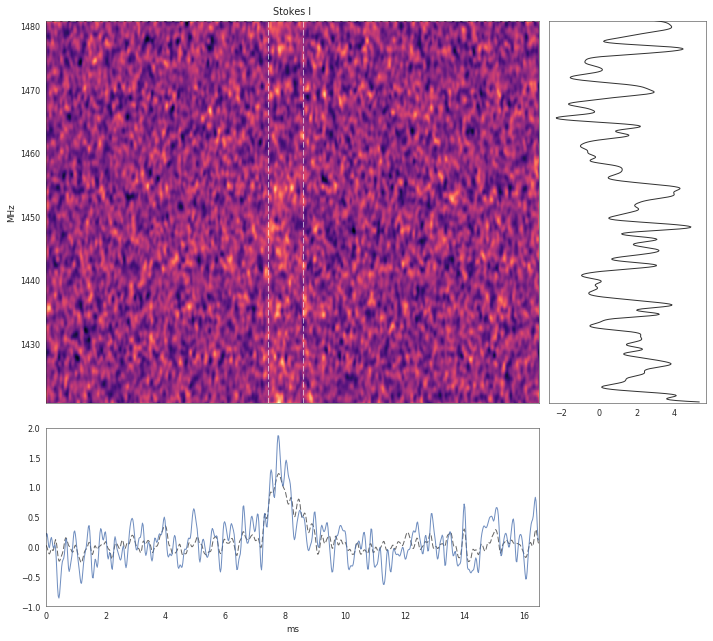

In [71]:
scatterNuIdx0 = 300
scatterNuIdx1 = 850
nch = 1

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]
for nchIdx in np.arange(nch):
    plt.axhline(y=freqsMHz[scatterNuIdx1] + (scatterBW / nch)*(1+nchIdx), c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k--', alpha=0.6)

for nchIdx in np.arange(nch):
    plt.plot(ts, np.mean(gaussSubData[0,pIdx,nchIdx*timeSeries.shape[2]/nch:(nchIdx+1)*timeSeries.shape[2]/nch],\
                         axis=0), alpha=0.8)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

In [72]:
#Scattering: bright scintile at 1420-1480 MHz

### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = 'FRB180301.scattering.ascii'
pdvfile = scatterutils.writePDVtimeSeries(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1].T,\
                                          freqsMHz[scatterNuIdx0:scatterNuIdx1], ts1/1e3, nch=1,\
                                          src='FRB180301_1420_1440', ofn=pdvfilen)

Pulsar name: FRB180301_1420_1440
Number of channels: 1
Number of bins: 721
RMS: 0.445974
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:339
Rolling data by -21 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 186
    # data points      = 721
    # variables        = 5
    chi-square         = 82.458
    reduced chi-square = 0.115
    Akaike info crit   = -1553.378
    Bayesian info crit = -1530.475
[[Variables]]
    mu:      349.080288 +/- 1.186980 (0.34%) (init= 360)
    sigma:   8.05313547 +/- 1.291893 (16.04%) (init= 15)
    A:       3.35786966 +/- 0.571009 (17.01%) (init= 1.98691)
    tau:     23.0192021 +/- 3.213712 (13.96%) (init= 200)
    dc:     -0.09198489 +/- 0.013866 (15.08%) (init= 0)
    nbins:   721 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.935 
    C(mu, tau)                   = -0.

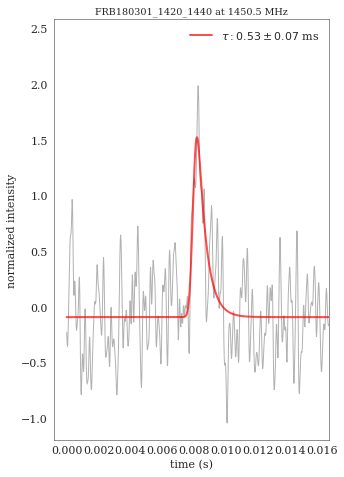

Tau (ms): 0.53
tau1GHz_alpha_4 (ms) ~ 2.33 



In [73]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

scatterFreqs, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [74]:
print 'Gaussian width (W10): %f ms pm %f'%((8.05313547 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)),\
                                     (1.291893 * (ts[1] - ts[0])) * 2. * np.sqrt(2. * np.log(10.)))

print 'Tau: %f ms pm %f'%((23.0192021 * (ts[1] - ts[0])), (3.213712 * (ts[1] - ts[0])))

Gaussian width (W10): 0.791006 ms pm 0.126894
Tau: 0.526808 ms pm 0.073548


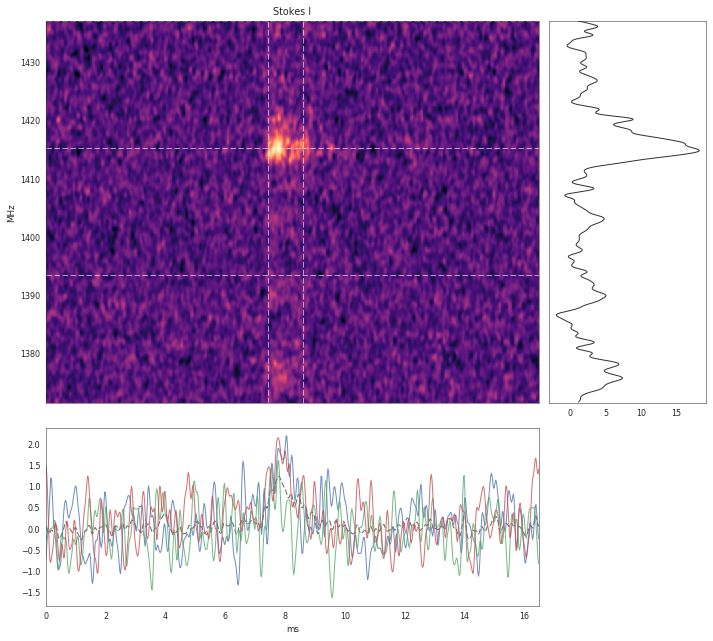

In [75]:
scatterNuIdx0 = 700
scatterNuIdx1 = 1300
nch = 3

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]
for nchIdx in np.arange(nch):
    plt.axhline(y=freqsMHz[scatterNuIdx1] + (scatterBW / nch)*(1+nchIdx), c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k--', alpha=0.6)

for nchIdx in np.arange(nch):
    plt.plot(ts, np.mean(gaussSubData[0,pIdx,nchIdx*timeSeries.shape[2]/nch:(nchIdx+1)*timeSeries.shape[2]/nch],\
                         axis=0), alpha=0.8)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

In [76]:
### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = 'FRB180301.scattering.ascii'
pdvfile = scatterutils.writePDVtimeSeries(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1].T,\
                                          freqsMHz[scatterNuIdx0:scatterNuIdx1], ts1/1e3, nch=nch,\
                                          src='FRB180301', ofn=pdvfilen)

Pulsar name: FRB180301
Number of channels: 3
Number of bins: 721
RMS: 0.902127
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:340
Rolling data by -20 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 103
    # data points      = 721
    # variables        = 5
    chi-square         = 233.995
    reduced chi-square = 0.327
    Akaike info crit   = -801.371
    Bayesian info crit = -778.468
[[Variables]]
    mu:      347.990595 +/- 0.611126 (0.18%) (init= 360)
    sigma:   7.21792899 +/- 0.717874 (9.95%) (init= 15)
    A:       12.3773495 +/- 1.297549 (10.48%) (init= 4.861114)
    tau:     29.7359709 +/- 1.991632 (6.70%) (init= 200)
    dc:     -0.31891930 +/- 0.023829 (7.47%) (init= 0)
    nbins:   721 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.945 
    C(A, tau)                    =  0.640 
    C(mu

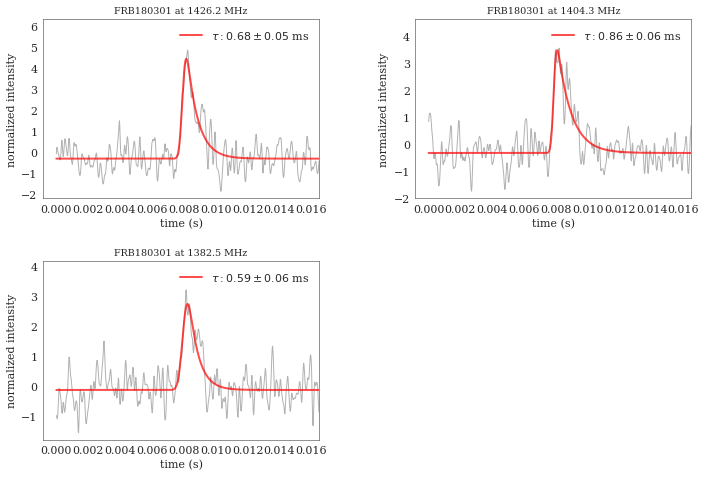

Tau (ms): 0.68
tau1GHz_alpha_4 (ms) ~ 2.81 

Tau (ms): 0.86
tau1GHz_alpha_4 (ms) ~ 3.35 

Tau (ms): 0.59
tau1GHz_alpha_4 (ms) ~ 2.14 



In [77]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

scatterFreqs, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [78]:
tauserr_nonzero = tauserr[np.nonzero(tauserr)]
taus = taus[np.nonzero(tauserr)]
print taus

[ 0.0006796   0.00086167  0.00058719]


[[Variables]]
    exponent:   -0.34938501 +/- 11.50922 (3294.14%) (init= 4.74222)
    amplitude:   0.00080683 +/- 0.003216 (398.62%) (init= 0.0001400522)
[[Correlations]] (unreported correlations are <  0.100)
    C(exponent, amplitude)       = -0.999 


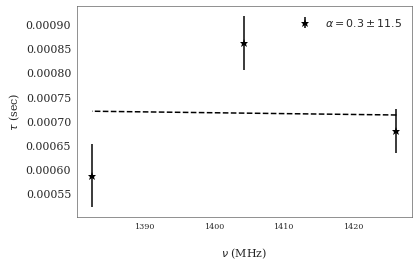

In [79]:
### produce_tauspectrum
### lmfit power law fit (weighted: 1/tauerr^2) for all non-zero tauerr
alpha, alphaerr = scatterutils.produce_tauspectrum(scatterFreqs, taus, tauserr)

### Pulse Width

[[Model]]
    (Model(constant) + Model(gaussian, prefix='nc0'))
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 721
    # variables        = 4
    chi-square         = 9.881
    reduced chi-square = 0.014
    Akaike info crit   = -3085.142
    Bayesian info crit = -3066.819
[[Variables]]
    c:              0.02042464 +/- 0.004779 (23.40%) (init= 0)
    nc0sigma:       0.50696561 +/- 0.013770 (2.72%) (init= 1)
    nc0center:      7.93164661 +/- 0.013343 (0.17%) (init= 7.5)
    nc0amplitude:   1.27913965 +/- 0.031876 (2.49%) (init= 1)
    nc0fwhm:        1.19381278 +/- 0.032427 (2.72%)  == '2.3548200*nc0sigma'
    nc0height:      1.00658288 +/- 0.023191 (2.30%)  == '0.3989423*nc0amplitude/max(1.e-15, nc0sigma)'
[[Correlations]] (unreported correlations are <  0.100)
    C(nc0sigma, nc0amplitude)    =  0.612 
    C(c, nc0amplitude)           = -0.404 
    C(c, nc0sigma)               = -0.247 

NCOMPONENTS: 1
0 Centre (ms): 7.931647 FWHM (ms): 1.193813 Amp: 1.2791

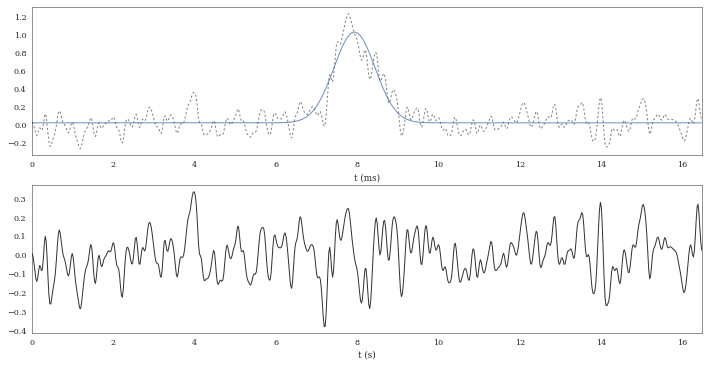

In [80]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 1 # number of components in profile

profileModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    profileModel += gaussComp

#print pulseModel
profileParams = profileModel.make_params(nc0center=7.5, nc0sigma=1.)

profileResult = profileModel.fit(timeSeries[0,0], profileParams, x=ts)
print profileResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(ts, timeSeries[0,0], lineColor, ls=':', alpha=0.5)
plt.plot(ts, profileResult.best_fit, alpha=0.8)
plt.xlim(ts[0], ts[-1])
plt.xlabel('t (ms)')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(ts, timeSeries[0,0] - profileResult.best_fit, lineColor, alpha=0.8)
plt.xlim(ts[0], ts[-1])
plt.xlabel('t (s)')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print '%i Centre (ms): %f FWHM (ms): %f Amp: %f'%(nc, profileResult.params['nc%icenter'%nc].value,\
                        profileResult.params['nc%ifwhm'%nc].value, profileResult.params['nc%iamplitude'%nc].value)

In [81]:
# W10: full width at tenth of maximum (FWTM)
# 2 * sqrt(2 * ln 2) * sigma
W10 = 2. * np.sqrt(2. * np.log(2.)) * profileResult.params['nc0sigma']
print W10
# W50: full width at half maximum (FWHM)
# 2 * sqrt(2 * ln 10) * sigma
W50 = 2. * np.sqrt(2. * np.log(10.)) * profileResult.params['nc0sigma']
print W50
print 2. * np.sqrt(2. * np.log(10.)) * 0.013772

1.19381280363
2.17586199314
0.0591084882281


Fluence (Jy ms): 1.29556952381


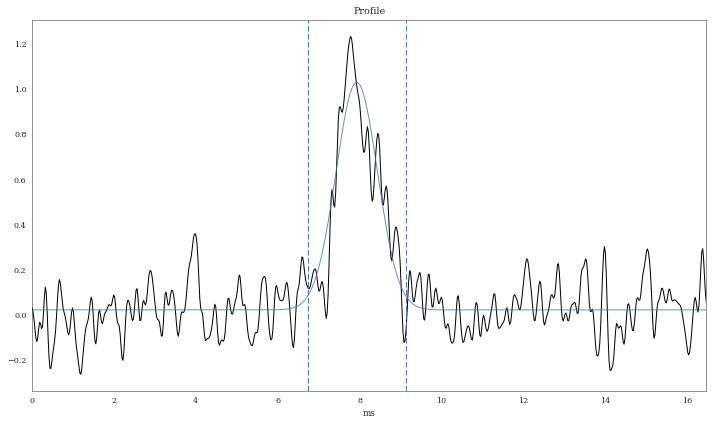

In [82]:
# fluence
fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(ts, timeSeries[0,0], 'k', label='I', alpha=1.)
plt.plot(ts, profileResult.best_fit, alpha=0.8)

plt.axvline(profileResult.params['nc0center'].value - W10, ls='--')
plt.axvline(profileResult.params['nc0center'].value + W10, ls='--')
f0tIdx = (np.abs(ts - (profileResult.params['nc0center'].value - W10))).argmin()
f1tIdx = (np.abs(ts - (profileResult.params['nc0center'].value + W10))).argmin()
fluence = np.sum(timeSeries[0,0,f0tIdx:f1tIdx]) * (ts[1] - ts[0]) # integrated flux - Jy ms
print 'Fluence (Jy ms):', fluence

plt.xlim(ts0, ts1)
plt.xlabel('ms')

plt.title('Profile')
plt.tight_layout()

[[Model]]
    ((Model(constant) + Model(gaussian, prefix='nc0')) + Model(gaussian, prefix='nc1'))
[[Fit Statistics]]
    # function evals   = 206
    # data points      = 721
    # variables        = 7
    chi-square         = 8.496
    reduced chi-square = 0.012
    Akaike info crit   = -3188.005
    Bayesian info crit = -3155.941
[[Variables]]
    c:              0.01933786 +/- 0.004506 (23.31%) (init= 0)
    nc0sigma:       0.20543788 +/- 0.022079 (10.75%) (init= 1)
    nc0center:      7.70099221 +/- 0.016620 (0.22%) (init= 7.5)
    nc0amplitude:   0.30911446 +/- 0.055037 (17.80%) (init= 1)
    nc1sigma:       0.56137745 +/- 0.023171 (4.13%) (init= 1)
    nc1center:      8.10809949 +/- 0.040550 (0.50%) (init= 9.5)
    nc1amplitude:   0.98795774 +/- 0.066702 (6.75%) (init= 1)
    nc0fwhm:        0.48376925 +/- 0.051992 (10.75%)  == '2.3548200*nc0sigma'
    nc0height:      0.60027307 +/- 0.060384 (10.06%)  == '0.3989423*nc0amplitude/max(1.e-15, nc0sigma)'
    nc1fwhm:        1.3219428

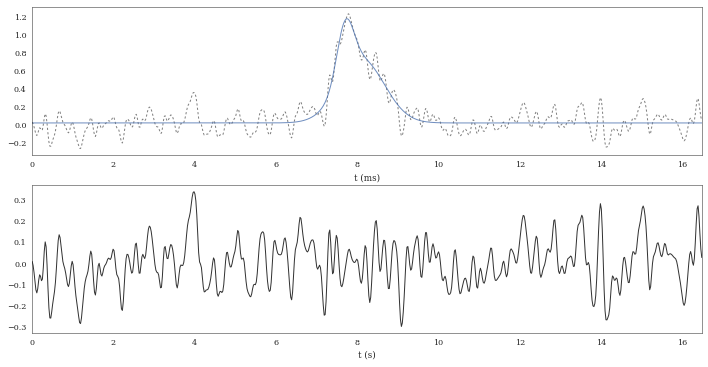

In [83]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 2 # number of components in profile

profileModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    profileModel += gaussComp

#print pulseModel
profileParams = profileModel.make_params(nc0center=7.5, nc0sigma=1.,\
                                         nc1center=9.5, nc1sigma=1.)

profileResult = profileModel.fit(timeSeries[0,0], profileParams, x=ts)
print profileResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(ts, timeSeries[0,0], lineColor, ls=':', alpha=0.5)
plt.plot(ts, profileResult.best_fit, alpha=0.8)
plt.xlim(ts[0], ts[-1])
plt.xlabel('t (ms)')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(ts, timeSeries[0,0] - profileResult.best_fit, lineColor, alpha=0.8)
plt.xlim(ts[0], ts[-1])
plt.xlabel('t (s)')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print '%i Centre (ms): %f FWHM (ms): %f Amp: %f'%(nc, profileResult.params['nc%icenter'%nc].value,\
                        profileResult.params['nc%ifwhm'%nc].value, profileResult.params['nc%iamplitude'%nc].value)

In [84]:
print np.abs(profileResult.params['nc0center'] - profileResult.params['nc1center'])
print 2. * np.sqrt(2. * np.log(10.)) * 0.20540695, 2. * np.sqrt(2. * np.log(10.)) * 0.022076
print 2. * np.sqrt(2. * np.log(10.)) * 0.56139080, 2. * np.sqrt(2. * np.log(10.)) * 0.023166

0.407107279902
0.881592672527 0.0947486919927
2.40945116854 0.09942689793


---

### Scintillation and Spectrum Fitting

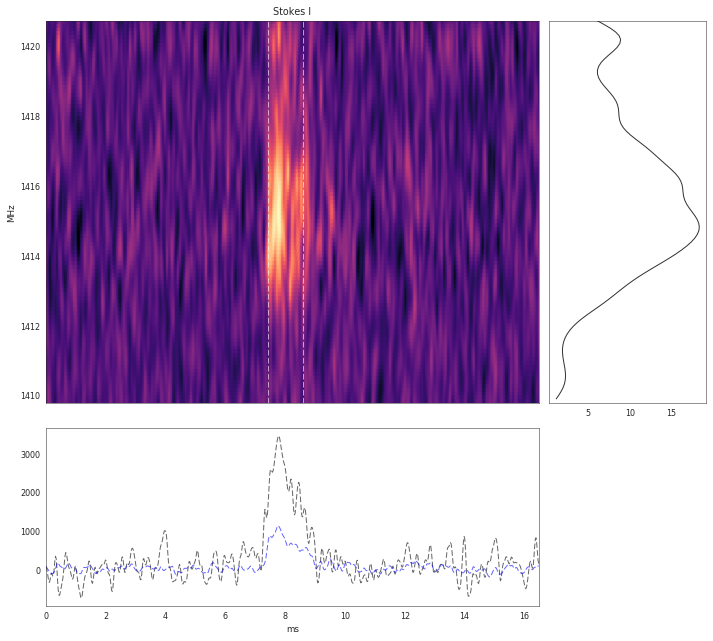

In [85]:
scatterNuIdx0 = 850
scatterNuIdx1 = 950

# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx,scatterNuIdx0:scatterNuIdx1], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[scatterNuIdx1], freqsMHz[scatterNuIdx0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

scatterBW = freqsMHz[scatterNuIdx0] - freqsMHz[scatterNuIdx1]

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

scintTimeSeries = np.sum(gaussSubData[:,:,scatterNuIdx0:scatterNuIdx1], axis=2)
sumTimeSeries = np.sum(gaussSubData, axis=2)

plt.plot(ts, sumTimeSeries[0,pIdx], 'k--', alpha=0.6)
plt.plot(ts, scintTimeSeries[0,pIdx], 'b--', alpha=0.6)
#plt.plot(ts, scintTimeSeries[0,pIdx] / sumTimeSeries[0,pIdx], 'k--', alpha=0.6)

plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
plt.plot(spectrum[0,pIdx,scatterNuIdx0:scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0:scatterNuIdx1],\
         'k', alpha=0.8)
plt.ylim(np.flipud(freqsMHz)[scatterNuIdx1], np.flipud(freqsMHz)[scatterNuIdx0])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

[[Model]]
    ((((((((((Model(constant) + Model(gaussian, prefix='nc0')) + Model(gaussian, prefix='nc1')) + Model(gaussian, prefix='nc2')) + Model(gaussian, prefix='nc3')) + Model(gaussian, prefix='nc4')) + Model(gaussian, prefix='nc5')) + Model(gaussian, prefix='nc6')) + Model(gaussian, prefix='nc7')) + Model(gaussian, prefix='nc8')) + Model(gaussian, prefix='nc9'))
[[Fit Statistics]]
    # function evals   = 1420
    # data points      = 2816
    # variables        = 31
    chi-square         = 2182.169
    reduced chi-square = 0.784
    Akaike info crit   = -656.075
    Bayesian info crit = -471.840
[[Variables]]
    nc0sigma:       1.77970694 +/- 0.356312 (20.02%) (init= 3)
    nc0amplitude:  -379.345700 +/- 1.52e+03 (401.44%) (init= 10)
    nc1sigma:       2.81750996 +/- 0.099147 (3.52%) (init= 3)
    nc1amplitude:   45.5980887 +/- 1.456602 (3.19%) (init= 10)
    nc2sigma:       1.70763268 +/- 0.099043 (5.80%) (init= 3)
    nc2amplitude:   19.0678320 +/- 1.097654 (5.76%) (init= 10

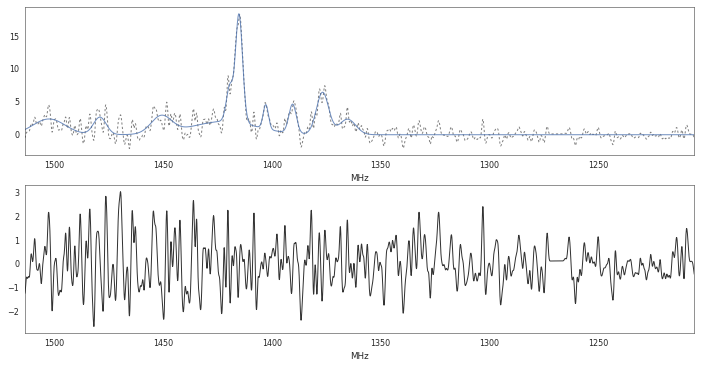

In [86]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 10 # number of components in spectrum

spectrumModel = lmfit.models.ConstantModel()
params = lmfit.Parameters()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    params.add('nc%isigma'%nc, value=3., min=0., max=20.)
    params.add('nc%iamplitude'%nc, value=10.)
    spectrumModel += gaussComp

params.add('c', value=0.)
params.add('nc0center', value=1415.)
params.add('nc1center', value=1375.)
params.add('nc2center', value=1390.)
params.add('nc3center', value=1400.)
params.add('nc4center', value=1450.)
params.add('nc5center', value=1420.)
params.add('nc6center', value=1360.)
params.add('nc7center', value=1475.)
params.add('nc8center', value=1500.)
params.add('nc9center', value=1433.)

"""
params = spectrumModel.make_params(nc0center=1415., nc0sigma=3.,\
                                   nc1center=1375., nc1sigma=3.,\
                                   nc2center=1390., nc2sigma=3.,\
                                   nc3center=1400., nc3sigma=3.,\
                                   nc4center=1450., nc4sigma=3.,\
                                   nc5center=1420., nc5sigma=3.,\
                                   nc6center=1360., nc6sigma=3.,\
                                   nc7center=1475., nc7sigma=3.,\
                                   nc8center=1500., nc8sigma=3.,\
                                   nc9center=1433., nc9sigma=3.)
"""

specResult = spectrumModel.fit(spectrum[0,0], params, x=freqsMHz)
print specResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(freqsMHz, spectrum[0,0], lineColor, ls=':', alpha=0.5)
plt.plot(freqsMHz, specResult.best_fit, alpha=0.8)
plt.xlim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('MHz')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(freqsMHz, spectrum[0,0] - specResult.best_fit, lineColor, alpha=0.8)
plt.xlim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('MHz')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print '%i Centre (MHz): %f sigma (MHz): %f Amp: %f'%(nc, specResult.params['nc%icenter'%nc].value,\
                        specResult.params['nc%isigma'%nc].value, specResult.params['nc%iamplitude'%nc].value)

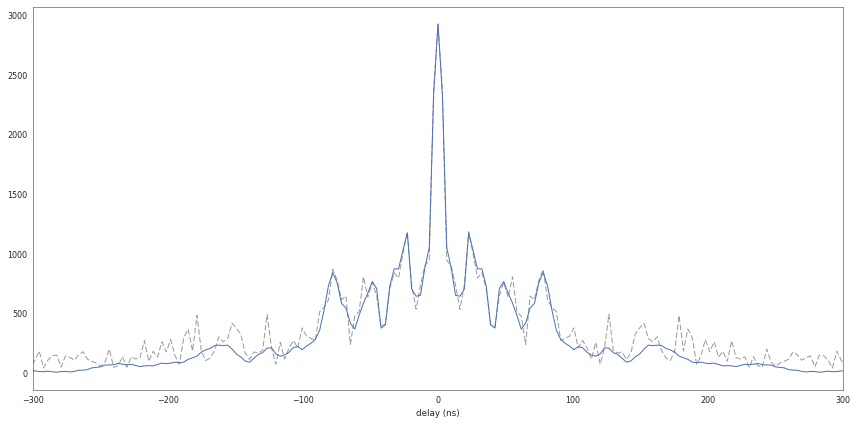

In [87]:
# delay spectrum
fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(np.fft.fftshift(np.fft.fftfreq(spectrum[0,0].shape[0], d=deltaNu*1e6)) * 1e9,
         np.abs(np.fft.fftshift(np.fft.fft(spectrum[0,0]))),\
         'k--', alpha=0.4)

plt.plot(np.fft.fftshift(np.fft.fftfreq(spectrum[0,0].shape[0], d=deltaNu*1e6)) * 1e9,
         np.abs(np.fft.fftshift(np.fft.fft(specResult.best_fit))),\
         alpha=1.)

plt.xlim(-300, 300)
plt.xlabel('delay (ns)')

plt.tight_layout()

[[Model]]
    (((Model(constant) + Model(gaussian, prefix='nc0')) + Model(gaussian, prefix='nc1')) + Model(gaussian, prefix='nc2'))
[[Fit Statistics]]
    # function evals   = 197
    # data points      = 5632
    # variables        = 10
    chi-square         = 48.668
    reduced chi-square = 0.009
    Akaike info crit   = -26738.715
    Bayesian info crit = -26672.352
[[Variables]]
    c:             -0.04587867 +/- 0        (0.00%) (init= 0)
    nc0sigma:       2.95108271 +/- 0        (0.00%) (init= 5)
    nc0center:     -3.2517e-11 +/- 0        (0.00%) (init= 0)
    nc0amplitude:   12.2506960 +/- 0        (0.00%) (init= 10000)
    nc1sigma:       59.0908215 +/- 0        (0.00%) (init= 75)
    nc1center:     -2.1693e-09 +/- 0        (0.00%) (init= 0)
    nc1amplitude:   180.956216 +/- 0        (0.00%) (init= 10000)
    nc2sigma:       0.72317823 +/- 0        (0.00%) (init= 10)
    nc2center:      1.4888e-10 +/- 0        (0.00%) (init= 0)
    nc2amplitude:   1.04395388 +/- 0        (

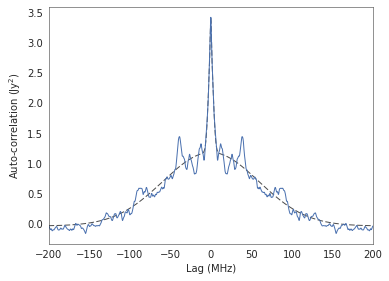

In [100]:
# Spectrum Auto-Correlation Function
padSpectrum = np.pad(spectrum[0,0], (0, spectrum[0,0].shape[0]), 'constant', constant_values=(0,0))
ACF = np.zeros(spectrum[0,0].shape[0])
freqLags = np.zeros(spectrum[0,0].shape[0])
for lIdx in np.arange(spectrum[0,0].shape[0]):
    ACF[lIdx] = np.mean(padSpectrum * np.roll(padSpectrum, lIdx))
    freqLags[lIdx] = freqsMHz[0] - freqsMHz[lIdx]

fullACF = np.concatenate((np.flipud(ACF), ACF))
fullFreqLags = np.concatenate((-1.*np.flipud(freqLags), freqLags))

# lag spectrum model
nComponents = 3 # number of components in lag spectrum

lagSpecModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    lagSpecModel += gaussComp

#print pulseModel
lagSpecParams = lagSpecModel.make_params(nc0center=0., nc0sigma=5., nc0amplitude=10000.,\
                                         nc1center=0., nc1sigma=75., nc1amplitude=10000.,\
                                         nc2center=0., nc2sigma=10., nc2amplitude=10000.)

lagSpecResult = lagSpecModel.fit(fullACF, lagSpecParams, x=fullFreqLags)
print lagSpecResult.fit_report()

# delay spectrum
#fig = plt.figure(figsize=(12,6)) # (width, height)
fig = plt.figure(figsize=(5.5,4)) # (width, height)

ax = fig.add_subplot(111)

plt.plot(fullFreqLags, lagSpecResult.best_fit, c='black', alpha=0.7, ls='--')

#plt.axvline(-12.5, ls='--', c='green')
#plt.axvline(12.5, ls='--', c='green')
#plt.axvline(-26., ls=':', c='green')
#plt.axvline(26., ls=':', c='green')

#plt.axvline(-39., ls='--', c='red')
#plt.axvline(39., ls='--', c='red')
#plt.axvline(-80., ls=':', c='red')
#plt.axvline(80., ls=':', c='red')

plt.plot(fullFreqLags, fullACF)

plt.xlim(-200, 200)
plt.xlabel('Lag (MHz)', fontsize=10)
plt.ylabel('Auto-correlation (Jy$^{2})$', fontsize=10)

ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../figures/acf.pdf')
#plt.savefig('lag_spectrum_180301.png')

np.savez('lag_spectrum.npz', fullACF, fullFreqLags)

In [89]:
# Auto-Correlation Function (Flippin' Slow)
#import scipy.signal
#pIdx = 0 # Stokes I

#ACF2D = scipy.signal.correlate2d(gaussSubData[0,pIdx], gaussSubData[0,pIdx])
#print ACF2D.shape

In [90]:
# Auto-Correlation Function (Fast with FFTs)
pIdx = 0 # Stokes I

ACF2Dfft = np.abs(np.fft.ifft2(np.fft.fft2(gaussSubData[0,pIdx], norm='ortho') *\
                               np.fft.fft2(gaussSubData[0,pIdx], norm='ortho'), norm='ortho'))
ACF2Dfft = np.fft.ifftshift(ACF2Dfft)

timeLags = np.fft.ifftshift(np.fft.fftfreq(ACF2Dfft.shape[0], d=deltaNu*1e6) * 1e9) # ns
freqLags = np.fft.ifftshift(np.fft.fftfreq(ACF2Dfft.shape[1], d=(ts[1]-ts[0])/1e3)/1e3) # kHz

print gaussSubData[0,pIdx].shape
print ACF2Dfft.shape

(2816, 721)
(2816, 721)


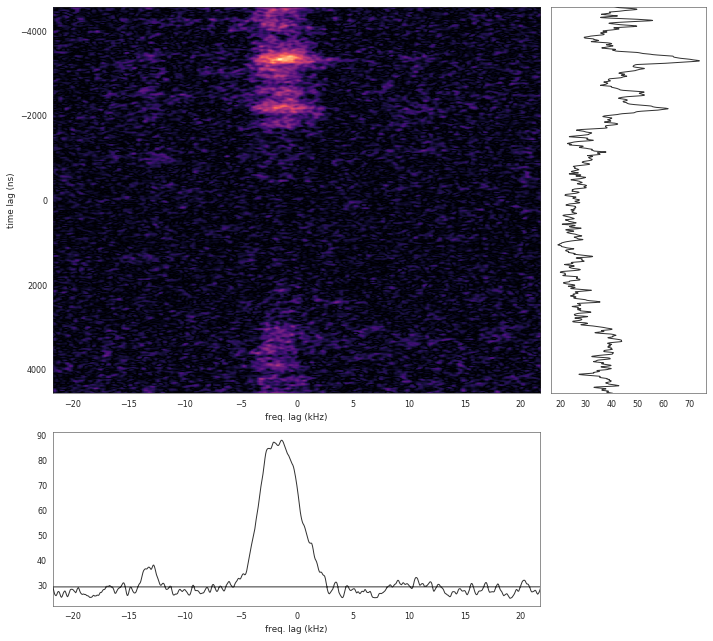

In [91]:
# Auto-Correlation Function

ACF2D = ACF2Dfft.copy()

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

acfPlot = plt.imshow(ACF2D, aspect='auto',\
                     extent=(freqLags[1], freqLags[-1], timeLags[0], timeLags[-1]),\
                     cmap=plt.get_cmap(cmap), interpolation='nearest')

#ax1.get_xaxis().set_visible(False)

plt.xlabel('freq. lag (kHz)')
plt.ylabel('time lag (ns)')

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

freqLagSpec = np.mean(ACF2D, axis=0)

plt.plot(freqLags, freqLagSpec, 'k', alpha=0.8)
plt.xlabel('freq. lag (kHz)')
plt.xlim(freqLags[1], freqLags[-1])

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

timeLagSpec = np.mean(ACF2D, axis=1)

plt.plot(timeLagSpec, np.flipud(timeLags), 'k', alpha=0.8)
plt.ylabel('time lag (ns)')
plt.ylim(timeLags[0], timeLags[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

---

### Verification Heat Map

In [92]:
import cPickle as pkl
import pandas as pd
from matplotlib import colors

In [93]:
criteria = {} # criteria status dictionary
criteria['DMexcess'] = 'POSITIVE'
criteria['SNR'] = 'POSITIVE'
criteria['flux'] = 'POSITIVE'
criteria['pulsewidth'] = 'POSITIVE'
criteria['multicomp'] = 'POSITIVE'
criteria['polarization'] = 'NEGATIVE'
criteria['broadband'] = 'NEUTRAL'
criteria['spectralIndex'] = 'NEUTRAL'
criteria['highResStruct'] = 'NEUTRAL'
criteria['scattering'] = 'NEUTRAL'
criteria['scintillation'] = 'NEUTRAL'
criteria['dmSpace'] = 'POSITIVE'
criteria['dispersionRelation'] = 'NEUTRAL'
criteria['bandpass'] = 'POSITIVE'
criteria['telState'] = 'POSITIVE'
criteria['rfi'] = 'NEGATIVE'
criteria['repeats'] = 'POSITIVE'
criteria['gain'] = 'NEGATIVE'
criteria['lowSNRsearch'] = 'POSITIVE'
criteria['multiBeam'] = 'POSITIVE'
criteria['TAB'] = 'NOTVALID'
criteria['interferometric'] = 'NOTVALID'
criteria['multiSite'] = 'NOTVALID'
criteria['lowAltitude'] = 'NEUTRAL'
criteria['localTime'] = 'NEUTRAL'
criteria['dataSingleBeam'] = 'NOTVALID'
criteria['dataMultiBeam'] = 'POSITIVE'
criteria['dataTAB'] = 'NOTVALID'
criteria['dataInterferometric'] = 'NOTVALID'
criteria['dataMultiSite'] = 'NOTVALID'
criteria['dataVoltages'] = 'VALID'

In [94]:
for key in criteria.iterkeys():
    print '%s: %s'%(key, criteria[key])

outFn = 'criteria.FRB180301.pkl'
ofh = open(outFn, 'wb')
pkl.dump(criteria, ofh)
ofh.close()

dataInterferometric: NOTVALID
multiSite: NOTVALID
multicomp: POSITIVE
lowAltitude: NEUTRAL
scattering: NEUTRAL
spectralIndex: NEUTRAL
flux: POSITIVE
broadband: NEUTRAL
multiBeam: POSITIVE
polarization: NEGATIVE
pulsewidth: POSITIVE
DMexcess: POSITIVE
TAB: NOTVALID
dispersionRelation: NEUTRAL
telState: POSITIVE
interferometric: NOTVALID
gain: NEGATIVE
dataVoltages: VALID
dataMultiBeam: POSITIVE
dataTAB: NOTVALID
localTime: NEUTRAL
dmSpace: POSITIVE
lowSNRsearch: POSITIVE
dataMultiSite: NOTVALID
highResStruct: NEUTRAL
SNR: POSITIVE
rfi: NEGATIVE
repeats: POSITIVE
scintillation: NEUTRAL
bandpass: POSITIVE
dataSingleBeam: NOTVALID


In [95]:
colOrder = ['SNR', 'flux', 'pulsewidth', 'highResStruct', 'multicomp', 'broadband',\
            'spectralIndex', 'scattering', 'scintillation', 'polarization',\
            'DMexcess',\
            'dispersionRelation', 'dmSpace', 'repeats', 'lowSNRsearch', 'rfi',\
            'telState',\
            'bandpass', 'gain', 'lowAltitude', 'localTime',\
            'multiBeam',\
            'TAB', 'interferometric', 'multiSite',\
           ]

CritLblDict = {
    'DMexcess':'DM Excess',
    'SNR':'S/N',
    'flux':'Flux',
    'pulsewidth':'Pulse Width',
    'multicomp':'Multiple Components',
    'polarization':'Polarization',
    'broadband':'Broad-band',
    'spectralIndex':'Spectral Index',
    'highResStruct':'High-resolution Structure',
    'scattering':'Scattering',
    'scintillation':'Scintillation',
    'dmSpace':'DM Trial Space',
    'dispersionRelation':'Dispersion Relation',
    'bandpass':'Bandpass',
    'lowAltitude':'Pointing',
    'telState':'Telescope State',
    'repeats':'Repeats',
    'gain':'Gain Stability',
    'lowSNRsearch':'Low-S/N DM Search',
    'rfi':'RFI Environment',
    'localTime':'Local Time',
    'multiBeam':'Multi-Beam Obs',
    'TAB':'Tied-Array Beam Obs',
    'interferometric':'Interferometric Obs',
    'multiSite':'Multi-Site Obs',
}

In [96]:
criteriaFile = 'criteria.FRB180301.pkl'

FRBCrits = {}
TerrCrits = {}

FRBName = 'FRB 180301'
critDict = pkl.load(open(criteriaFile, 'rb'))
FRBCrits[FRBName] = pd.Series(critDict)

FRBdf = pd.DataFrame(FRBCrits).transpose()
FRBdf.sort_index(inplace=True)
FRBdf['empty'] = np.nan
FRBdf = FRBdf[colOrder]
FRBdf.rename(columns=CritLblDict, inplace=True)

numDf = FRBdf.copy()

for strIdx, strVal in enumerate(['POSITIVE', 'NEUTRAL', 'UNKNOWN', 'NEGATIVE', 'CRITICAL', 'NOTVALID']):
    numDf.replace(to_replace=strVal, value=strIdx, inplace=True)

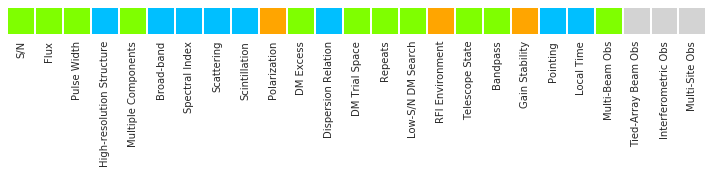

In [101]:
cmap = colors.ListedColormap(['chartreuse', 'deepskyblue', '#FFFF33', 'orange', 'orangered', 'lightgrey'])

fig = plt.figure(figsize=(10,3)) # (width, height)

ax = sns.heatmap(numDf, cmap=cmap, cbar=False, square=True, linewidths=1)
ax.get_yaxis().set_visible(False)
ax.tick_params(labelsize=10)
fig.tight_layout()

plt.savefig('../figures/verificationHeatmap.pdf')